# Recurrent Neural Network (LSTM)  外汇交易预测
基于 TensorFlow 2.0，两层 LSTM 层，Keras sequential() 实现

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## 读取数据

In [2]:
mpl.rcParams['figure.figsize'] = (16, 8)

In [3]:
# Load Time Series data
data_file="GBPUSD.pro1440.csv"
df = pd.read_csv(data_file, parse_dates=['Date'])

# Data Overview
df

,Date,Time,Open,High,Low,Close,Volume
0,2012-01-20,00:00,1.54860,1.55770,1.54500,1.55740,79844
1,2012-01-23,00:00,1.55540,1.56010,1.55160,1.55650,82459
2,2012-01-24,00:00,1.55650,1.56250,1.55320,1.56240,76263
3,2012-01-25,00:00,1.56250,1.56780,1.55330,1.56570,84081
4,2012-01-26,00:00,1.56560,1.57330,1.56490,1.56880,77611
...,...,...,...,...,...,...,...
2043,2019-10-30,00:00,1.28682,1.29072,1.28377,1.28966,152018
2044,2019-10-31,00:00,1.28960,1.29756,1.28929,1.29405,167251
2045,2019-11-01,00:00,1.29402,1.29723,1.29239,1.29404,156924
2046,2019-11-04,00:00,1.29171,1.29424,1.28758,1.28814,133989


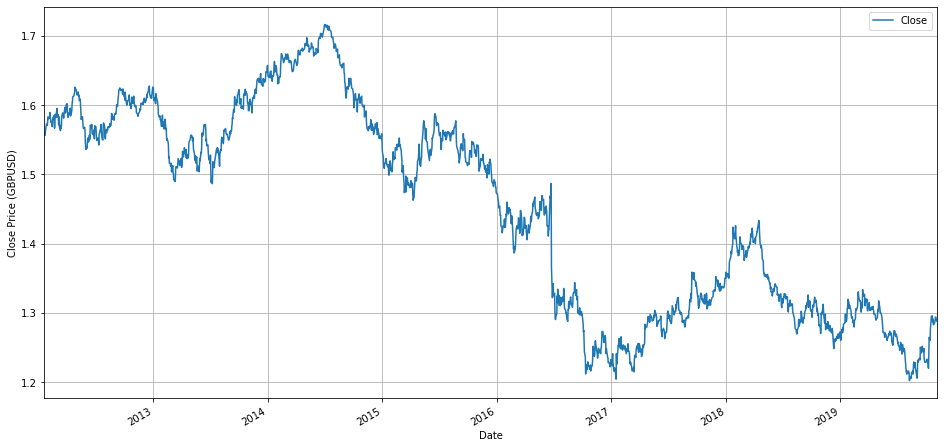

In [4]:
# Plot the Close Price Trend
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (GBPUSD)")
plt.grid()

## 数据预处理

### 数据标准化

In [5]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close

array([[0.69052157],
       [0.68877134],
       [0.70024503],
       ...,
       [0.17836724],
       [0.16689355],
       [0.16922718]])

### 生成训练集测试集

In [7]:
# Making sequences
# [batch_size, sequence_length, n_features]
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

In [15]:
# Split the sequences into training data and testing data
def data_preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = data_preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

## 模型构建和训练

### 构建模型

In [9]:
# Model
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
model.add(tf.keras.layers.LSTM(WINDOW_SIZE,return_sequences=True,input_shape=
(WINDOW_SIZE, X_train.shape[-1])))
model.add(tf.keras.layers.LSTM(WINDOW_SIZE, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mae')

### 模型训练

In [10]:
# Training
BATCH_SIZE = 50
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 1577 samples, validate on 176 samples
Epoch 1/50
1577/1577 [==============================] - 21s 14ms/sample - loss: 0.1722 - val_loss: 0.0326
Epoch 2/50
1577/1577 [==============================] - 16s 10ms/sample - loss: 0.1048 - val_loss: 0.0378
Epoch 3/50
1577/1577 [==============================] - 17s 11ms/sample - loss: 0.0764 - val_loss: 0.0256
Epoch 4/50
1577/1577 [==============================] - 16s 10ms/sample - loss: 0.0705 - val_loss: 0.0206
Epoch 5/50
1577/1577 [==============================] - 17s 11ms/sample - loss: 0.0578 - val_loss: 0.0209
Epoch 6/50
1577/1577 [==============================] - 17s 11ms/sample - loss: 0.0417 - val_loss: 0.0214
Epoch 7/50
1577/1577 [==============================] - 23s 14ms/sample - loss: 0.0357 - val_loss: 0.0213
Epoch 8/50
1577/1577 [==============================] - 23s 14ms/sample - loss: 0.0366 - val_loss: 0.0229
Epoch 9/50
1577/1577 [==============================] - 22s 14ms/sample - loss: 0.0355 - val_loss: 0.0211

### 模型评估

In [11]:
model.evaluate(X_test, y_test)

195/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.018072096821971428

### 可视化模型 loss

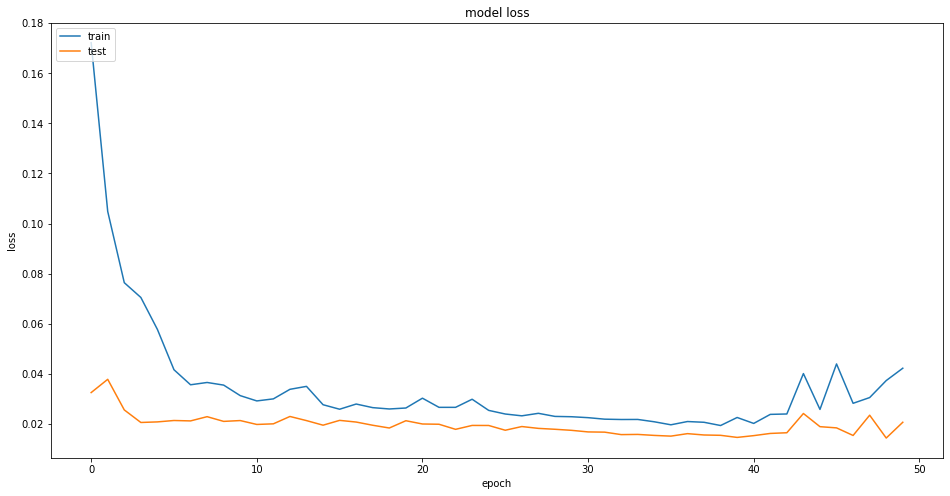

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 进行预测

In [13]:
y_hat = model.predict(X_test)

### 可视化预测结果

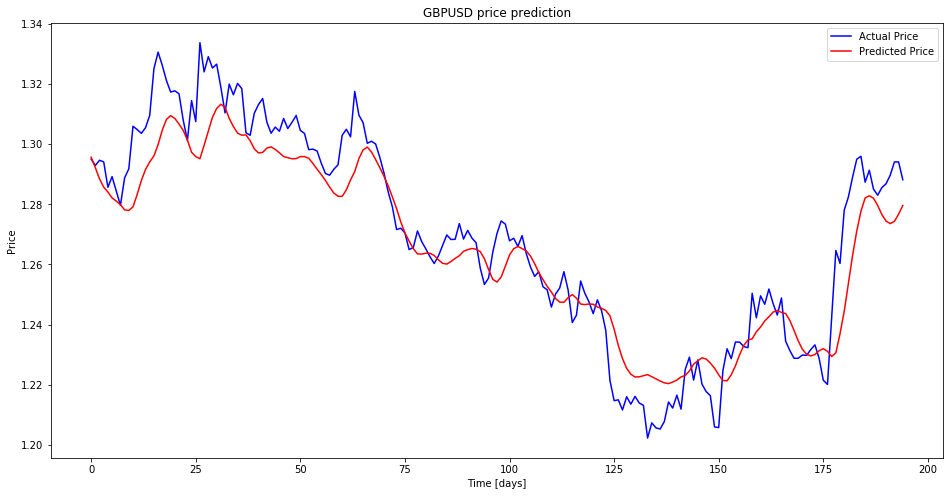

In [14]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
plt.title('GBPUSD price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()